In [7]:
import matplotlib.pyplot as plt
import random
import sys
sys.path.append('../src')

from data import *
from model import *
from train import *
import random
from make_cosmic_web import *

import cmasher as cmr

ROOT = Path("..").resolve()
tng_base_path = f"{ROOT}/illustris_data/TNG300-1/output"

seed = 255
rng = np.random.RandomState(seed)
random.seed(seed)
torch.manual_seed(seed)

c0, c1, c2, c3, c4 = '#003f5c', '#58508d', '#bc5090', '#ff6361', '#ffa600'

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [8]:
reload = False #force a reload of the data to change cuts, use_loops, periodic or use_loops

## get illustris positions
snapshot = 99
h = 0.704 # cosmology h, set to 1 if you want comoving Mpc

r_link = 5 #Mpc

cuts = {"minimum_log_stellar_mass": 9,
        "minimum_log_halo_mass": 10,
       "minimum_n_star_particles": 50}

undirected = True
periodic = False
use_loops = False

use_gal = False # True = use galaxy params to infer dark matter, False = use DM params to infer galaxy stuff

pad = r_link / 2 # how much padding to add around each subbox, so the separation in total will be 2 times this

split = 6 # N_subboxes = split**3

train_test_frac_split = 36

In [9]:
def make_webs(
    tng_base_path="../illustris_data/TNG300-1/output", 
    data_path=None,
    snapshot=99, 
    r_link=5,
    pad=2.5,
    split=6,
    cuts=cuts, 
    use_gal=False, 
    h=0.704, 
    undirected=True, 
    periodic=False, 
    use_loops=False,
    normalization_params=normalization_params
):
    
    if use_gal:
        # use_cols = ['subhalo_x', 'subhalo_y', 'subhalo_z', 'subhalo_vx', 'subhalo_vy', 'subhalo_vz','subhalo_logstellarmass', 'subhalo_stellarhalfmassradius']
        use_cols = ['subhalo_x', 'subhalo_y', 'subhalo_z', 'subhalo_vx', 'subhalo_vy', 'subhalo_vz','subhalo_logstellarmass']
        y_cols = ['subhalo_loghalomass', 'subhalo_logvmax'] 
    else:
        use_cols = ['subhalo_x', 'subhalo_y', 'subhalo_z', 'subhalo_vx', 'subhalo_vy', 'subhalo_vz', 'subhalo_loghalomass', 'subhalo_logvmax'] 
        # y_cols = ['subhalo_logstellarmass', 'subhalo_stellarhalfmassradius']
        y_cols = ['subhalo_logstellarmass']

    subhalo_fields = ["SubhaloPos", "SubhaloMassType"] #just an initial check here

    subhalos = il.groupcat.loadSubhalos(tng_base_path, snapshot, fields=subhalo_fields) 

    pos = subhalos["SubhaloPos"][:,:3]
    min_box, max_box = np.rint(np.min(pos)), np.rint(np.max(pos))

    box_size = max_box/(h*1e3) #/(h*1000), pos units are in kpc


    subhalo_fields = [
            "SubhaloPos", "SubhaloMassType", "SubhaloLenType", "SubhaloHalfmassRadType", 
            "SubhaloVel", "SubhaloVmax", "SubhaloGrNr", "SubhaloFlag"
        ]
    subhalos = il.groupcat.loadSubhalos(tng_base_path, snapshot, fields=subhalo_fields) 

    halo_fields = ["Group_M_Crit200", "GroupFirstSub", "GroupPos", "GroupVel"]
    halos = il.groupcat.loadHalos(tng_base_path, snapshot, fields=halo_fields)

    subhalo_pos = subhalos["SubhaloPos"][:] / (h*1e3) #/(h*1000), pos units are in comoving kpc, so now in Mpc
    subhalo_stellarmass = subhalos["SubhaloMassType"][:,4]
    subhalo_halomass = subhalos["SubhaloMassType"][:,1]
    subhalo_n_stellar_particles = subhalos["SubhaloLenType"][:,4]
    subhalo_stellarhalfmassradius = subhalos["SubhaloHalfmassRadType"][:,4]  / normalization_params["norm_half_mass_radius"]
    subhalo_vel = subhalos["SubhaloVel"][:] /  normalization_params["norm_velocity"]
    subhalo_vmax = subhalos["SubhaloVmax"][:] / normalization_params["norm_velocity"]
    subhalo_flag = subhalos["SubhaloFlag"][:]
    halo_id = subhalos["SubhaloGrNr"][:]

    halo_mass = halos["Group_M_Crit200"][:]
    halo_primarysubhalo = halos["GroupFirstSub"][:]  # currently not used but might be good for magnitude gap
    group_pos = halos["GroupPos"][:] / (h*1e3)
    group_vel = halos["GroupVel"][:]  / normalization_params["norm_velocity"]

    # get subhalos/galaxies      
    subhalos = pd.DataFrame(
        np.column_stack([halo_id, subhalo_flag, np.arange(len(subhalo_stellarmass)), subhalo_pos, subhalo_vel, subhalo_n_stellar_particles, subhalo_stellarmass, subhalo_halomass, subhalo_stellarhalfmassradius, subhalo_vmax]), 
        columns=['halo_id', 'subhalo_flag', 'subhalo_id', 'subhalo_x', 'subhalo_y', 'subhalo_z', 'subhalo_vx', 'subhalo_vy', 'subhalo_vz', 'subhalo_n_stellar_particles', 'subhalo_stellarmass', 'subhalo_halomass', 'subhalo_stellarhalfmassradius', 'subhalo_vmax'],
    )
    subhalos = subhalos[subhalos["subhalo_flag"] != 0].copy()
    subhalos['halo_id'] = subhalos['halo_id'].astype(int)
    subhalos['subhalo_id'] = subhalos['subhalo_id'].astype(int)

    subhalos.drop("subhalo_flag", axis=1, inplace=True)

    # impose stellar mass and particle cuts
    subhalos = subhalos[subhalos["subhalo_n_stellar_particles"] > cuts["minimum_n_star_particles"]].copy()
    subhalos["subhalo_logstellarmass"] = np.log10(subhalos["subhalo_stellarmass"])+10

    subhalos["subhalo_loghalomass"] = np.log10(subhalos["subhalo_halomass"])+10
    subhalos["subhalo_logvmax"] = np.log10(subhalos["subhalo_vmax"])
    subhalos["subhalo_logstellarhalfmassradius"] = np.log10(subhalos["subhalo_stellarhalfmassradius"])

    subhalos = subhalos[subhalos["subhalo_loghalomass"] > cuts["minimum_log_halo_mass"]].copy()

    subhalos = subhalos[subhalos["subhalo_logstellarmass"] > cuts["minimum_log_stellar_mass"]].copy()

    subhalos.reset_index(drop = True)

    data = []
    for n in range(split):
        for g in range(split):
            for k in range(split):
                print(n,g,k)
                xlims = np.array([box_size/split*n+pad, box_size/split*(n+1)-pad])
                ylims = np.array([box_size/split*g+pad, box_size/split*(g+1)-pad])
                zlims = np.array([box_size/split*k+pad, box_size/split*(k+1)-pad])

                pos = np.vstack(subhalos[['subhalo_x', 'subhalo_y', 'subhalo_z']].to_numpy())

                xmask = np.logical_and(pos[:,0]>xlims[0],pos[:,0]<xlims[1])
                ymask = np.logical_and(pos[:,1]>ylims[0],pos[:,1]<ylims[1])
                zmask = np.logical_and(pos[:,2]>zlims[0],pos[:,2]<zlims[1])
                mask = np.logical_and(zmask, np.logical_and(xmask, ymask))

                df = subhalos.iloc[mask].copy()
                df.reset_index(drop=True)

                # remove extraneous columns
                df.drop(["subhalo_n_stellar_particles", "subhalo_stellarmass", "subhalo_halomass"], axis=1, inplace=True)

                # set new zero point

                df[['subhalo_x', 'subhalo_y', 'subhalo_z']] = df[['subhalo_x', 'subhalo_y', 'subhalo_z']] - np.array([box_size/split*n+pad, box_size/split*g+pad, box_size/split*k+pad])

                #make positions for clustering

                pos = np.vstack(df[['subhalo_x', 'subhalo_y', 'subhalo_z']].to_numpy())

                kd_tree = ss.KDTree(pos, leafsize=25, boxsize=box_size)
                edge_index = kd_tree.query_pairs(r=r_link, output_type="ndarray")

                # normalize positions

                df[['subhalo_x', 'subhalo_y', 'subhalo_z']] = df[['subhalo_x', 'subhalo_y', 'subhalo_z']]/(box_size/2)

                if undirected:
                # Add reverse pairs
                    reversepairs = np.zeros((edge_index.shape[0],2))
                    for i, pair in enumerate(edge_index):
                        reversepairs[i] = np.array([pair[1], pair[0]])
                    edge_index = np.append(edge_index, reversepairs, 0)

                    edge_index = edge_index.astype(int)

                    # Write in pytorch-geometric format
                    edge_index = edge_index.reshape((2,-1))
                    num_pairs = edge_index.shape[1]

                row, col = edge_index

                diff = pos[row]-pos[col]
                dist = np.linalg.norm(diff, axis=1)

                if periodic:
                    # Take into account periodic boundary conditions, correcting the distances
                    for i, pos_i in enumerate(diff):
                        for j, coord in enumerate(pos_i):
                            if coord > r_link:
                                diff[i,j] -= box_size  # Boxsize normalize to 1
                            elif -coord > r_link:
                                diff[i,j] += box_size  # Boxsize normalize to 1

                centroid = np.mean(pos,axis=0) # define arbitrary coordinate, invarinat to translation/rotation shifts, but not stretches
                # centroid+=1.2

                unitrow = (pos[row]-centroid)/np.linalg.norm((pos[row]-centroid), axis=1).reshape(-1,1)
                unitcol = (pos[col]-centroid)/np.linalg.norm((pos[col]-centroid), axis=1).reshape(-1,1)
                unitdiff = diff/dist.reshape(-1,1)
                # Dot products between unit vectors
                cos1 = np.array([np.dot(unitrow[i,:].T,unitcol[i,:]) for i in range(num_pairs)])
                cos2 = np.array([np.dot(unitrow[i,:].T,unitdiff[i,:]) for i in range(num_pairs)])

                edge_attr = np.concatenate([dist.reshape(-1,1), cos1.reshape(-1,1), cos2.reshape(-1,1)], axis=1)

                if use_loops:
                    loops = np.zeros((2,pos.shape[0]),dtype=int)
                    atrloops = np.zeros((pos.shape[0],3))
                    for i, posit in enumerate(pos):
                        loops[0,i], loops[1,i] = i, i
                        atrloops[i,0], atrloops[i,1], atrloops[i,2] = 0., 1., 0.
                    edge_index = np.append(edge_index, loops, 1)
                    edge_attr = np.append(edge_attr, atrloops, 0)
                edge_index = edge_index.astype(int)

                x =  torch.tensor(np.vstack(df[use_cols].to_numpy()), dtype=torch.float)
                y =  torch.tensor(np.vstack(df[y_cols].to_numpy()), dtype=torch.float)
                edge_index = torch.tensor(edge_index, dtype=torch.long)
                edge_attr=torch.tensor(edge_attr, dtype=torch.float)
                pos = torch.tensor(pos, dtype=torch.float)

                data.append(Data(x=x, y=y, pos=pos, edge_index=edge_index, edge_attr=edge_attr))

                if data_path is None:
                    data_path = osp.join(tng_base_path, 'cosmic_graphs', f'split_{split**3}_link_{int(r_link)}_pad{int(pad)}_gal{int(use_gal)}.pkl')

                if not osp.isdir(osp.join(tng_base_path, 'cosmic_graphs')):
                    os.mkdir(osp.join(tng_base_path, 'cosmic_graphs'))

                with open(data_path, 'wb') as handle:
                    pickle.dump(data, handle)
                  

In [10]:
tng50_path = osp.join(tng_base_path, 'cosmic_graphs', f'tng50-test.pkl')

if osp.isfile(tng50_path) and not reload:
    print('TNG50 already exists')
else:
    print('Remaking TNG50')
    make_webs(
        tng_base_path="../illustris_data/TNG50-1/output",
        data_path=tng50_path,
        snapshot=snapshot, 
        r_link=r_link, 
        pad=0, 
        split=1,
        cuts=cuts, 
        use_gal=use_gal, 
        h=h, 
        undirected=undirected, 
        periodic=periodic,
        use_loops=use_loops
    )

data_tng50 = pickle.load(open(tng50_path, 'rb'))

TNG50 already exists


In [11]:
tng300_path = osp.join(tng_base_path, 'cosmic_graphs', f'split_{split**3}_link_{int(r_link)}_pad{int(pad)}_gal{int(use_gal)}.pkl')

if osp.isfile(tng300_path) and not reload:
    print('TNG300 already exists')
else:
    print('Remaking TNG300')
    make_webs(
        tng_base_path="../illustris_data/TNG50-1/output",
        data_path=None,
        snapshot=snapshot, 
        r_link=r_link, 
        pad=pad, 
        split=split,
        cuts=cuts, 
        use_gal=use_gal, 
        h=h, 
        undirected=undirected, 
        periodic=periodic,
        use_loops=use_loops
    )
    
data_tng300 = pickle.load(open(tng300_path, 'rb'))

TNG300 already exists


# Train on TNG50, Test on TNG300

In [12]:
node_features = data_tng50[0].x.shape[1]
out_features = data_tng50[0].y.shape[1]

model = EdgePointGNN(
    node_features=node_features, 
    n_layers=1, 
    D_link=r_link,
    hidden_channels=128,
    latent_channels=128,
    loop=True,
    estimate_all_subhalos=True,
    use_global_pooling=False,
    n_out=out_features
)

model.to(device)


EdgePointGNN(
  (layers): ModuleList(
    (0): EdgePointLayer()
  )
  (fc): Sequential(
    (0): Linear(in_features=128, out_features=128, bias=True)
    (1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=128, bias=True)
    (4): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=2, bias=True)
  )
)

In [7]:
from train import *

batch_size = 64

train_loader = DataLoader(data_tng50, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(data_tng300, batch_size=batch_size, shuffle=False)

In [8]:
training_params = dict(
    batch_size=batch_size,
    learning_rate=1e-2,
    weight_decay=1e-4,
    n_epochs=500,
    valid_frac=0.15, # fraction of dataset for validation
    test_frac=0.0,  # fraction of dataset for testing
)

optimizer = torch.optim.AdamW(
    model.parameters(), 
    lr=training_params["learning_rate"], 
    weight_decay=training_params["weight_decay"]
)


train_losses = []
valid_losses = []
for epoch in range(training_params["n_epochs"]):

    # anneal 
    if (epoch == 300):
        optimizer = torch.optim.AdamW(
            model.parameters(), 
            lr=training_params["learning_rate"] / 5, 
            weight_decay=training_params["weight_decay"] / 5
        )
    elif (epoch == 400):
        optimizer = torch.optim.AdamW(
            model.parameters(), 
            lr=training_params["learning_rate"] / 25, 
            weight_decay=training_params["weight_decay"] / 25
        )

    train_loss = train(train_loader, model, optimizer, device, in_projection=False)
    valid_loss, valid_std, *_ = validate(valid_loader, model, device)

    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch + 1: >3d}    train loss: {train_loss: >5.2f}     valid loss: {valid_loss: >5.2f}     average valid std: {np.mean(valid_std): >5.3f}")



Epoch  10    train loss: -0.34     valid loss: -2.43     average valid std: 0.002
Epoch  20    train loss: -1.75     valid loss: -1.78     average valid std: 0.001
Epoch  30    train loss: -1.85     valid loss: -2.37     average valid std: 0.000
Epoch  40    train loss: -2.09     valid loss: -2.40     average valid std: 0.000
Epoch  50    train loss: -2.08     valid loss: -2.37     average valid std: 0.000
Epoch  60    train loss: -2.10     valid loss: -2.44     average valid std: 0.000
Epoch  70    train loss: -2.10     valid loss: -2.44     average valid std: 0.000
Epoch  80    train loss: -2.10     valid loss: -2.43     average valid std: 0.000
Epoch  90    train loss: -2.10     valid loss: -2.44     average valid std: 0.000
Epoch 100    train loss: -2.10     valid loss: -2.44     average valid std: 0.000
Epoch 110    train loss: -2.10     valid loss: -2.44     average valid std: 0.000
Epoch 120    train loss: -2.11     valid loss: -2.44     average valid std: 0.000
Epoch 130    tra

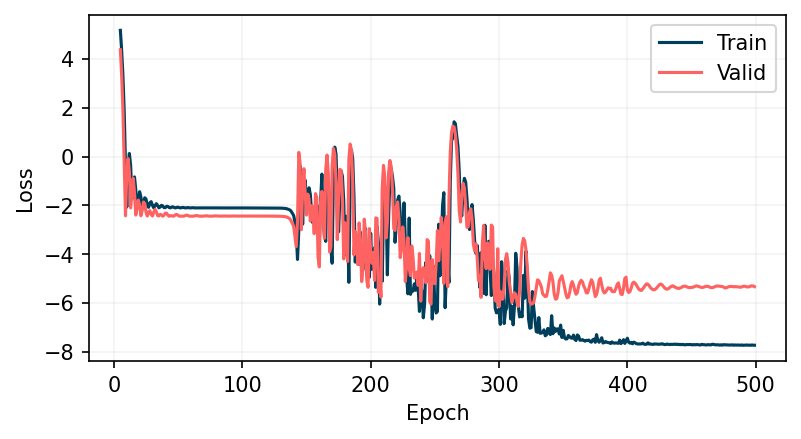

In [9]:
plt.figure(figsize=(6, 3), dpi=150)
plt.plot(np.arange(5, training_params["n_epochs"]), train_losses[5:], c=c0, label="Train")
plt.plot(np.arange(5, training_params["n_epochs"]), valid_losses[5:], c=c3, label="Valid")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(alpha=0.15)

In [10]:
_, _, p_tng300, y_tng300, _ = validate(valid_loader, model, device)

p_tng300 = p_tng300.reshape((-1, 1))

p_log_Mstar_tng300 = p_tng300[:, 0]
y_log_Mstar_tng300 = y_tng300[:, 0]

# for plotting purposes
log_Mhalo_tng300 = np.concatenate([d.x[:, -2] for d in data_tng300])

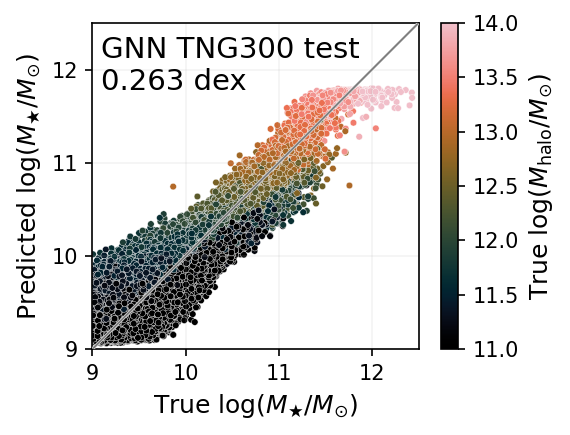

In [13]:
plt.figure(figsize=(4, 3), dpi=150)
plt.scatter(y_log_Mstar_tng300, p_log_Mstar_tng300, c=log_Mhalo_tng300, edgecolor='white', linewidths=0.2, s=10, cmap=cmr.dusk, vmin=11, vmax=14)
cb = plt.colorbar()
cb.set_label("True log($M_{\\rm halo}/M_{\\odot}}$)", fontsize=12)
plt.text(0.025, 0.96, f"GNN TNG300 test\n{np.sqrt(np.mean((p_log_Mstar_tng300 - y_log_Mstar_tng300)**2)):.3f} dex", va="top", transform=plt.gca().transAxes, fontsize=14)
plt.plot([0, 50], [0, 50], lw=1.5, c='w', zorder=9)
plt.plot([0, 50], [0, 50], lw=1, c='0.5', zorder=10)
plt.grid(alpha=0.15)
plt.xlim(9, 12.5)
plt.ylim(9, 12.5)
plt.xticks([9, 10, 11, 12])
plt.yticks([9, 10, 11, 12])

plt.xlabel("True log($M_{\\bigstar}/M_{\\odot}}$)", fontsize=12)
plt.ylabel("Predicted log($M_{\\bigstar}/M_{\\odot}}$)", fontsize=12)
plt.gca().set_aspect("equal")
# plt.title("Equivariant Graph Neural Network", fontsize=14)
plt.tight_layout()

# Train on a combination of TNG50 + 300, test on a subset of TNG300

In [13]:
from train import *

batch_size = 64

train_loader = DataLoader(data_tng50*10 + data_tng300[:-36], batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(data_tng300[-36:], batch_size=batch_size, shuffle=False)

In [14]:
training_params = dict(
    batch_size=batch_size,
    learning_rate=1e-2,
    weight_decay=1e-4,
    n_epochs=500,
    valid_frac=0.15, # fraction of dataset for validation
    test_frac=0.0,  # fraction of dataset for testing
)

optimizer = torch.optim.AdamW(
    model.parameters(), 
    lr=training_params["learning_rate"], 
    weight_decay=training_params["weight_decay"]
)


train_losses = []
valid_losses = []
for epoch in range(training_params["n_epochs"]):

    # anneal 
    if (epoch == 300):
        optimizer = torch.optim.AdamW(
            model.parameters(), 
            lr=training_params["learning_rate"] / 5, 
            weight_decay=training_params["weight_decay"] / 5
        )
    elif (epoch == 400):
        optimizer = torch.optim.AdamW(
            model.parameters(), 
            lr=training_params["learning_rate"] / 25, 
            weight_decay=training_params["weight_decay"] / 25
        )

    train_loss = train(train_loader, model, optimizer, device, in_projection=False)
    valid_loss, valid_std, *_ = validate(valid_loader, model, device)

    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch + 1: >3d}    train loss: {train_loss: >5.2f}     valid loss: {valid_loss: >5.2f}     average valid std: {np.mean(valid_std): >5.3f}")



Epoch  10    train loss: -2.20     valid loss: -2.43     average valid std: 0.001
Epoch  20    train loss: -2.39     valid loss: -2.46     average valid std: 0.000
Epoch  30    train loss: -2.39     valid loss: -2.46     average valid std: 0.000
Epoch  40    train loss: -2.39     valid loss: -2.46     average valid std: 0.000
Epoch  50    train loss: -2.39     valid loss: -2.46     average valid std: 0.000
Epoch  60    train loss: -2.43     valid loss: -2.54     average valid std: 0.000
Epoch  70    train loss: -4.04     valid loss: -3.86     average valid std: 0.001
Epoch  80    train loss: -5.27     valid loss: -3.70     average valid std: 0.001
Epoch  90    train loss: -4.12     valid loss: -3.50     average valid std: 0.000
Epoch 100    train loss: -5.28     valid loss: -4.40     average valid std: 0.001
Epoch 110    train loss: -5.72     valid loss: -5.43     average valid std: 0.001
Epoch 120    train loss: -6.11     valid loss: -5.20     average valid std: 0.001
Epoch 130    tra

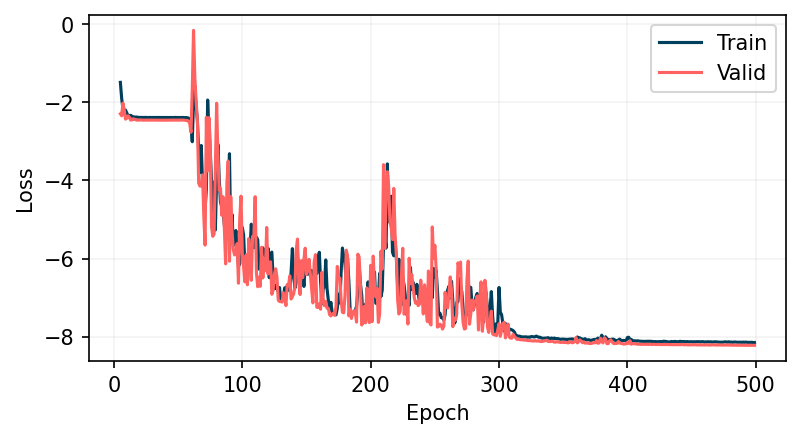

In [18]:
plt.figure(figsize=(6, 3), dpi=150)
plt.plot(np.arange(5, training_params["n_epochs"]), train_losses[5:], c=c0, label="Train")
plt.plot(np.arange(5, training_params["n_epochs"]), valid_losses[5:], c=c3, label="Valid")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(alpha=0.15)

In [21]:
_, _, p_tng300, y_tng300, _ = validate(valid_loader, model, device)

p_tng300 = p_tng300.reshape((-1, 1))

p_log_Mstar_tng300 = p_tng300[:, 0]
y_log_Mstar_tng300 = y_tng300[:, 0]

# for plotting purposes
log_Mhalo_tng300 = np.concatenate([d.x[:, -2] for d in data_tng300[-36:]])

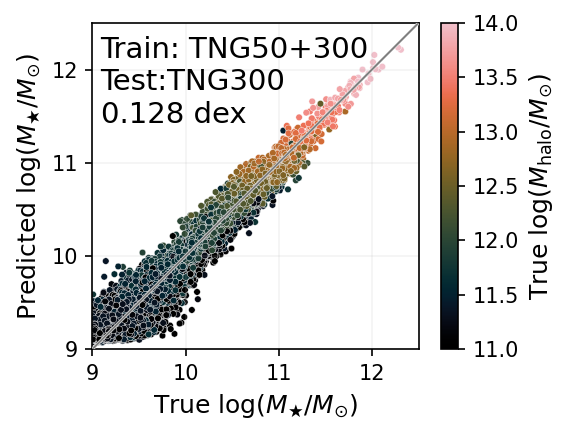

In [22]:
plt.figure(figsize=(4, 3), dpi=150)
plt.scatter(y_log_Mstar_tng300, p_log_Mstar_tng300, c=log_Mhalo_tng300, edgecolor='white', linewidths=0.2, s=10, cmap=cmr.dusk, vmin=11, vmax=14)
cb = plt.colorbar()
cb.set_label("True log($M_{\\rm halo}/M_{\\odot}}$)", fontsize=12)
plt.text(0.025, 0.96, f"Train: TNG50+300\nTest:TNG300\n{np.sqrt(np.mean((p_log_Mstar_tng300 - y_log_Mstar_tng300)**2)):.3f} dex", va="top", transform=plt.gca().transAxes, fontsize=14)
plt.plot([0, 50], [0, 50], lw=1.5, c='w', zorder=9)
plt.plot([0, 50], [0, 50], lw=1, c='0.5', zorder=10)
plt.grid(alpha=0.15)
plt.xlim(9, 12.5)
plt.ylim(9, 12.5)
plt.xticks([9, 10, 11, 12])
plt.yticks([9, 10, 11, 12])

plt.xlabel("True log($M_{\\bigstar}/M_{\\odot}}$)", fontsize=12)
plt.ylabel("Predicted log($M_{\\bigstar}/M_{\\odot}}$)", fontsize=12)
plt.gca().set_aspect("equal")
# plt.title("Equivariant Graph Neural Network", fontsize=14)
plt.tight_layout()

# Train on TNG50+300 and Test on TNG50

In [23]:
tng50_path = osp.join(tng_base_path, 'cosmic_graphs', f'tng50-split2.pkl')

if osp.isfile(tng50_path) and not reload:
    print('TNG50 already exists')
else:
    print('Remaking TNG50')
    make_webs(
        tng_base_path="../illustris_data/TNG50-1/output",
        data_path=tng50_path,
        snapshot=snapshot, 
        r_link=r_link, 
        pad=r_link/2, 
        split=2,
        cuts=cuts, 
        use_gal=use_gal, 
        h=h, 
        undirected=undirected, 
        periodic=periodic,
        use_loops=use_loops
    )

data_tng50 = pickle.load(open(tng50_path, 'rb'))

Remaking TNG50
0 0 0
0 0 1
0 1 0
0 1 1
1 0 0
1 0 1
1 1 0
1 1 1


/home/john/miniconda3/envs/pyg/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [25]:
data_tng50

[Data(x=[89, 8], edge_index=[2, 1152], edge_attr=[1152, 3], y=[89, 1], pos=[89, 3]),
 Data(x=[105, 8], edge_index=[2, 962], edge_attr=[962, 3], y=[105, 1], pos=[105, 3]),
 Data(x=[81, 8], edge_index=[2, 618], edge_attr=[618, 3], y=[81, 1], pos=[81, 3]),
 Data(x=[295, 8], edge_index=[2, 14408], edge_attr=[14408, 3], y=[295, 1], pos=[295, 3]),
 Data(x=[293, 8], edge_index=[2, 13088], edge_attr=[13088, 3], y=[293, 1], pos=[293, 3]),
 Data(x=[147, 8], edge_index=[2, 2678], edge_attr=[2678, 3], y=[147, 1], pos=[147, 3]),
 Data(x=[169, 8], edge_index=[2, 2620], edge_attr=[2620, 3], y=[169, 1], pos=[169, 3]),
 Data(x=[97, 8], edge_index=[2, 1646], edge_attr=[1646, 3], y=[97, 1], pos=[97, 3])]

In [26]:
data_tng300[:5]

[Data(x=[370, 8], edge_index=[2, 4004], edge_attr=[4004, 3], y=[370, 1], pos=[370, 3]),
 Data(x=[590, 8], edge_index=[2, 17308], edge_attr=[17308, 3], y=[590, 1], pos=[590, 3]),
 Data(x=[360, 8], edge_index=[2, 2538], edge_attr=[2538, 3], y=[360, 1], pos=[360, 3]),
 Data(x=[887, 8], edge_index=[2, 38432], edge_attr=[38432, 3], y=[887, 1], pos=[887, 3]),
 Data(x=[1242, 8], edge_index=[2, 51200], edge_attr=[51200, 3], y=[1242, 1], pos=[1242, 3])]

In [27]:
from train import *

batch_size = 64

train_loader = DataLoader(100*data_tng50[:-1] + data_tng300, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(data_tng50[-1:], batch_size=batch_size, shuffle=False)

In [29]:
node_features = data_tng50[0].x.shape[1]
out_features = data_tng50[0].y.shape[1]

model = EdgePointGNN(
    node_features=node_features, 
    n_layers=1, 
    D_link=r_link,
    hidden_channels=128,
    latent_channels=128,
    loop=True,
    estimate_all_subhalos=True,
    use_global_pooling=False,
    n_out=out_features
)

model.to(device)


EdgePointGNN(
  (layers): ModuleList(
    (0): EdgePointLayer()
  )
  (fc): Sequential(
    (0): Linear(in_features=128, out_features=128, bias=True)
    (1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=128, bias=True)
    (4): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=2, bias=True)
  )
)

In [30]:
training_params = dict(
    batch_size=batch_size,
    learning_rate=1e-2,
    weight_decay=1e-4,
    n_epochs=500,
    valid_frac=0.15, # fraction of dataset for validation
    test_frac=0.0,  # fraction of dataset for testing
)

optimizer = torch.optim.AdamW(
    model.parameters(), 
    lr=training_params["learning_rate"], 
    weight_decay=training_params["weight_decay"]
)


train_losses = []
valid_losses = []
for epoch in range(training_params["n_epochs"]):

    # anneal 
    if (epoch == 300):
        optimizer = torch.optim.AdamW(
            model.parameters(), 
            lr=training_params["learning_rate"] / 5, 
            weight_decay=training_params["weight_decay"] / 5
        )
    elif (epoch == 400):
        optimizer = torch.optim.AdamW(
            model.parameters(), 
            lr=training_params["learning_rate"] / 25, 
            weight_decay=training_params["weight_decay"] / 25
        )

    train_loss = train(train_loader, model, optimizer, device, in_projection=False)
    valid_loss, valid_std, *_ = validate(valid_loader, model, device)

    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch + 1: >3d}    train loss: {train_loss: >5.2f}     valid loss: {valid_loss: >5.2f}     average valid std: {np.mean(valid_std): >5.3f}")



Epoch  10    train loss: -2.26     valid loss: -2.33     average valid std: 0.001
Epoch  20    train loss: -5.70     valid loss: -5.51     average valid std: 0.002
Epoch  30    train loss: -6.32     valid loss: -5.15     average valid std: 0.001
Epoch  40    train loss: -6.57     valid loss: -7.83     average valid std: 0.001
Epoch  50    train loss: -5.85     valid loss: -6.86     average valid std: 0.001
Epoch  60    train loss: -6.94     valid loss: -7.65     average valid std: 0.001
Epoch  70    train loss: -6.49     valid loss: -7.84     average valid std: 0.001
Epoch  80    train loss: -6.38     valid loss: -6.84     average valid std: 0.001
Epoch  90    train loss: -7.18     valid loss: -7.86     average valid std: 0.001
Epoch 100    train loss: -7.64     valid loss: -8.18     average valid std: 0.001
Epoch 110    train loss: -7.35     valid loss: -7.48     average valid std: 0.001
Epoch 120    train loss: -6.69     valid loss: -5.87     average valid std: 0.001
Epoch 130    tra

In [32]:
_, _, p_valid, y_valid, _ = validate(valid_loader, model, device)

p_valid = p_valid.reshape((-1, 1))

p_log_Mstar_valid = p_valid[:, 0]
y_log_Mstar_valid = y_valid[:, 0]

# for plotting purposes
log_Mhalo_valid = np.concatenate([d.x[:, -2] for d in data_tng50[-1:]])

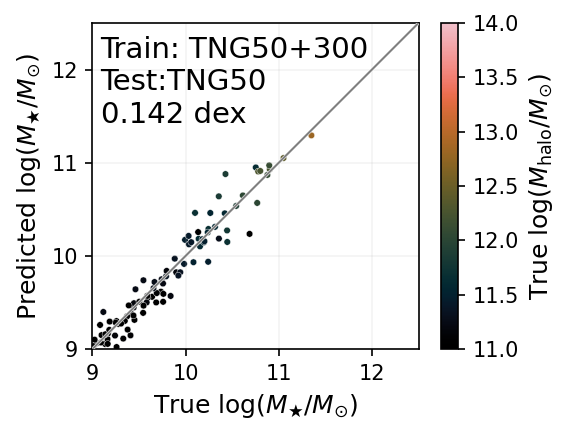

In [33]:
plt.figure(figsize=(4, 3), dpi=150)
plt.scatter(y_log_Mstar_valid, p_log_Mstar_valid, c=log_Mhalo_valid, edgecolor='white', linewidths=0.2, s=10, cmap=cmr.dusk, vmin=11, vmax=14)
cb = plt.colorbar()
cb.set_label("True log($M_{\\rm halo}/M_{\\odot}}$)", fontsize=12)
plt.text(0.025, 0.96, f"Train: TNG50+300\nTest:TNG50\n{np.sqrt(np.mean((p_log_Mstar_valid - y_log_Mstar_valid)**2)):.3f} dex", va="top", transform=plt.gca().transAxes, fontsize=14)
plt.plot([0, 50], [0, 50], lw=1.5, c='w', zorder=9)
plt.plot([0, 50], [0, 50], lw=1, c='0.5', zorder=10)
plt.grid(alpha=0.15)
plt.xlim(9, 12.5)
plt.ylim(9, 12.5)
plt.xticks([9, 10, 11, 12])
plt.yticks([9, 10, 11, 12])

plt.xlabel("True log($M_{\\bigstar}/M_{\\odot}}$)", fontsize=12)
plt.ylabel("Predicted log($M_{\\bigstar}/M_{\\odot}}$)", fontsize=12)
plt.gca().set_aspect("equal")
# plt.title("Equivariant Graph Neural Network", fontsize=14)
plt.tight_layout()